In [2]:
import cv2
from deepface import DeepFace
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
tf.config.optimizer.set_jit(False) # Disable Just-In-Time compilation

2025-12-22 21:37:53.011857: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-22 21:37:54.107478: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-22 21:37:56.529980: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [8]:
img_path_1 = "archive/Faces/Faces/Alexandra Daddario_2.jpg"
img_path_2 = "archive/Faces/Faces/Akshay Kumar_32.jpg"

with tf.device('/CPU:0'):
    result = DeepFace.verify(img1_path = img_path_1, img2_path = img_path_2)
result

{'verified': False,
 'distance': 0.863235,
 'threshold': 0.68,
 'confidence': 4.45,
 'model': 'VGG-Face',
 'detector_backend': 'opencv',
 'similarity_metric': 'cosine',
 'facial_areas': {'img1': {'x': 0,
   'y': 0,
   'w': 159,
   'h': 159,
   'left_eye': (121, 58),
   'right_eye': (40, 58)},
  'img2': {'x': 0,
   'y': 0,
   'w': 159,
   'h': 159,
   'left_eye': None,
   'right_eye': None}},
 'time': 0.31}

In [8]:
model = DeepFace.build_model("VGG-Face")

In [10]:
# img = cv2.imread(img_path_1)
# with tf.device('/CPU:0'):
#     embeddings1 = model.forward(img)

# img = cv2.imread(img_path_2)
# with tf.device('/CPU:0'):
#     embeddings2 = model.forward(img)

# embeddings1 = np.array(embeddings1) 
# embeddings2 = np.array(embeddings2)

# (embeddings1 @ embeddings2) / (np.linalg.norm(embeddings1) * np.linalg.norm(embeddings2))

np.float64(0.9017925806100135)

# Detect -> Recogination

In [11]:
import cv2
import os
face_cascade = cv2.CascadeClassifier()

cascade_path = os.path.join(cv2.data.haarcascades, 'haarcascade_frontalface_alt.xml')
if not face_cascade.load(cascade_path):
    print("--(!)Error loading face cascade")

def get_bbox_faces(frame):
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_gray = cv2.equalizeHist(frame_gray)

    return face_cascade.detectMultiScale(frame_gray)

In [12]:
THRESHOLD = 0.1
test_img_path = "test.jpg"
img_path_1 = "archive/Faces/Faces/Alexandra Daddario_2.jpg"

test_img = cv2.imread(test_img_path)
test_results =  DeepFace.represent(test_img_path)

img = cv2.imread(img_path_1)
img_result = DeepFace.represent(img_path_1)[0]

test_embeds = np.array([result['embedding'] for result in test_results]) # num_faces x embedding_dim
img_embeds = np.array(img_result['embedding']).reshape(1, -1)

similarity = (img_embeds @ test_embeds.T) / (np.linalg.norm(img_embeds) * np.linalg.norm(test_embeds))


output_img = test_img.copy()
for i, result in enumerate(test_results):
    area = result['facial_area']
    x, y, w, h = area['x'], area['y'], area['w'], area['h']

    print(similarity[0][i])
    if similarity[0][i] >= THRESHOLD: continue

    
    blurred_face = cv2.GaussianBlur(output_img[y:y+h, x:x+w], (33, 33), 30)
    output_img[y:y+h, x:x+w] = blurred_face

2025-12-22 21:38:54.382365: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-12-22 21:38:55.416731: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2025-12-22 21:38:56.463894: W external/local_xla/xla/service/gpu/llvm_gpu_backend/default/nvptx_libdevice_path.cc:41] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directo

0.02207387785030821
0.3295341570792705
0.005548898587120269
0.049307243558443556


In [13]:
output_img.shape

(612, 469, 3)

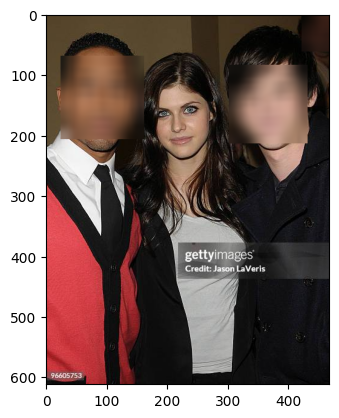

In [14]:
plt.imshow(output_img[:,:,::-1])

In [25]:
model.input_shape

(224, 224)

In [25]:
# from pathlib import Path
# folder_path = Path("archive/Faces/Alexandra_Daddario")
# folder_image_paths = [
#     p for p in folder_path.rglob("*") 
#     if p.suffix.lower() in {".jpg", ".jpeg", ".png"}
# ]
# print(f"FOUND: {len(folder_image_paths)} images")
# folder_results =  [DeepFace.represent(path, enforce_detection=False) for path in folder_image_paths]
# print(folder_results)
embeddings = np.array([result['embedding']  for image_results in folder_results for result in image_results])
bboxs = np.array([result['facial_area'] for image_results in folder_results for result in image_results])


In [27]:
name = "Alexandra_Daddario"
df = pd.DataFrame({"name": [name] * len(embeddings), "source_embeddings": list(embeddings)})

In [34]:
df.to_parquet("dataset.parquet")

ArrowKeyError: No type extension with name arrow.py_extension_type found

In [33]:
!pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 54.4 kB/s  0:11:20m0:00:0100:19m


In [28]:
df = pd.read_csv("dataset.csv")

In [31]:
df['source_embeddings'][0]

'[0. 0. 0. ... 0. 0. 0.]'